# Figure 3. Nick processing
---

In [2]:
import time
today = time.strftime('%Y-%m-%d')
name = 'Seungchan Baek'
print 'Last revised by %s at %s.' % (name, today)

Last revised by Seungchan Baek at 2020-12-01.


In [3]:
home = '/casa/bsc/projects/1_DCS/2004_paper_prep/'
utilpath = '/casa/bsc/notebooks/'
%cd $home

/casa/bsc/projects/1_DCS/2004_paper_prep


In [4]:
from __future__ import division
import sys; sys.path.append(utilpath)
from util import *
from basic import gen_result_dir
resultpath = gen_result_dir('results/')
print 'resultpath:', resultpath

resultpath: results/201201/


In [5]:
import pandas as pd
import numpy as np
import re
import gzip
from matplotlib import pyplot as plt
from matplotlib import lines, gridspec
from scipy.stats import mannwhitneyu, sem, ttest_ind, spearmanr
from collections import defaultdict, Counter
%matplotlib inline

In [6]:
LIBRARIES = [ 'set1', 'set2', 'set3', 'set4', 'set5' ]

In [7]:
s1 = pd.read_csv('supplementary/201123_s1__DROSHA_dependency.csv', header=1, index_col=0)
s2 = pd.read_csv('supplementary/201123_s2__Construct.csv', header=1, index_col=0).fillna('')
s3 = pd.read_csv('supplementary/201123_s3__DROSHA_processing_result.csv', header=1, index_col=0)
s5 = pd.read_csv('supplementary/201123_s5__Nick_processing.csv', header=1)
#s5 = pd.read_csv('supplementary/201012_s5_pri-structure.csv', header=1, index_col=0)
#s6 = pd.read_csv('supplementary/201028_s6_cleavage-patterns.csv', header=1, index_col=0)

In [8]:
preposition = {}
for mir in s2.index:
    flank5, flank3 = s2.loc[mir,["5' flanking segment","3' flanking segment"]]
    if flank5 or flank3:
        preposition[mir] = (len(flank5)+1,125-len(flank3))
    else:
        preposition[mir] = (0,126)
print len(preposition), preposition['hsa-mir-142']

1881 (32, 90)


In [9]:
constseqs = dict(s2['Construct sequence (125 nt)'])
print len(constseqs)

1881


In [10]:
drodep = s1[s1['DROSHA dependency'].apply(lambda x:x.find('DROSHA-dependent')>=0)].index
droind = s1[s1['DROSHA dependency'].apply(lambda x:x.find('DROSHA-independent')>=0)].index
droko = s1[s1['DROSHA dependency'].apply(lambda x:x.find('DROSHA KO')>=0)].index
fclip = s1[s1['DROSHA dependency'].apply(lambda x:x.find('fCLIP')>=0)].index
print len(drodep), len(droind), len(droko), len(fclip)

304 257 157 281


In [11]:
EFFCUT = 2.5
HOMCUT = .25
effs = s3['Cleavage Efficiency'].to_dict()
homs = s3['Cleavage Homogeneity'].to_dict()
dcsmirs = [ m for m in s3.index if effs[m]>=EFFCUT and homs[m]>=HOMCUT ]
nodcs = [ m for m in s3.index if m not in dcsmirs ]
print len(s3.index), len(dcsmirs), len(nodcs)

1816 534 1282


In [12]:
clvraw = pd.read_csv('supplementary/201012_s4_cleavage-product.csv',header=1,index_col=[0,1,2])
clvtbl = pd.DataFrame()
for lib in LIBRARIES:
    clvtbl[lib] = clvraw[['%s-1'%lib,'%s-2'%lib]].sum(axis=1)
clvtbl = clvtbl.reset_index()
clvtbl.head(1)

,Pri-miRNA,rstart,rend,set1,set2,set3,set4,set5
0,hsa-let-7a-1,1,8,4,4,0,0,0


In [13]:
START, MID, END = 1, 63, 125
clv5f = clvtbl[(clvtbl['rstart']==START)&(clvtbl['rend']<MID)].set_index('Pri-miRNA')
clv3f = clvtbl[(clvtbl['rstart']>MID)&(clvtbl['rend']==END)].set_index('Pri-miRNA')
clvhn = clvtbl[(clvtbl['rstart']<MID)&(clvtbl['rend']>MID)]
clvn5 = clvhn[clvhn['rstart']==START]
clvn3 = clvhn[clvhn['rend']==END]
clvh = clvhn.drop(clvn5.index).drop(clvn3.index).set_index('Pri-miRNA')
clvn5 = clvn5.set_index('Pri-miRNA'); clvn3 = clvn3.set_index('Pri-miRNA')

In [14]:
def fill_unfound(tbl):
    found = set(tbl.index)
    unfound = [ mir for mir in s2.index if mir not in found ]
    fill = pd.DataFrame(index=unfound, columns=tbl.columns).fillna(0)
    return tbl.append(fill)

In [15]:
clvtbl = fill_unfound(clvtbl.set_index('Pri-miRNA'))
clv5f = fill_unfound(clv5f)
clv3f = fill_unfound(clv3f)
clvh = fill_unfound(clvh)
clvn5 = fill_unfound(clvn5)
clvn3 = fill_unfound(clvn3)

---

## C. Reproducibility of 5p nick processing

In [17]:
preposition['hsa-mir-20a']

(31, 88)

In [16]:
mir = 'hsa-mir-20a'
unc3 = clvn3.loc[[mir]].reset_index().set_index(['rstart'])
unc3

,index,rend,set1,set2,set3,set4,set5
rstart,,,,,,,
10,hsa-mir-20a,125,2,0,0,0,0
13,hsa-mir-20a,125,3,0,0,0,0
16,hsa-mir-20a,125,4,0,0,0,0
17,hsa-mir-20a,125,4,1,0,0,0
18,hsa-mir-20a,125,1,0,0,0,0
20,hsa-mir-20a,125,3,0,0,0,0
24,hsa-mir-20a,125,1,0,0,0,0
25,hsa-mir-20a,125,3,1,0,0,0
27,hsa-mir-20a,125,23,4,0,0,0


In [18]:
S1, S2 = 'set1','set2'
RCUTOFFH, WINDOW = 10, 3
nick5, nick3 = {}, {}
for mir in s2.index:
    ps, pe = preposition[mir]
    if ps<1 or pe>125:
        continue
    unc5 = clvn5.loc[[mir]].reset_index().set_index(['rend'])
    unc5 = unc5.reindex(range(pe-WINDOW,pe+WINDOW+1)).sum()
    unc3 = clvn3.loc[[mir]].reset_index().set_index(['rstart'])
    unc3 = unc3.reindex(range(ps-WINDOW,ps+WINDOW+1)).sum()
    hpn = clvh.loc[[mir]]
    hpn = hpn[hpn.apply(lambda x: (x['rstart'] in range(ps-WINDOW,ps+WINDOW+1)) and 
                                  (x['rend'] in range(pe-WINDOW,pe+WINDOW+1)),axis=1)].sum()
    if hpn[S1]>=RCUTOFFH and hpn[S2]>=RCUTOFFH:
        nick5[mir] = ((unc3[S1]+1)/(hpn[S1]+1),(unc3[S2]+1)/(hpn[S2]+1))
        nick3[mir] = ((unc5[S1]+1)/(hpn[S1]+1),(unc5[S2]+1)/(hpn[S2]+1))
print len(nick5), len(nick3)

802 802


In [47]:
tmp = ['hsa-mir-10a','hsa-mir-10b','hsa-mir-20a','hsa-mir-17','hsa-mir-106a','hsa-mir-92a-1']
xs, ys = zip(*nick5.values())
xs2, ys2 = zip(*[nick5[m] for m in tmp])
r = spearmanr(xs, ys)[0]
xs = np.log2(xs)
ys = np.log2(ys)
xs2 = np.log2(xs2)
ys2 = np.log2(ys2)
print r

0.8536304200983681


Text(6,-12,u'$R_s$ = 0.85')

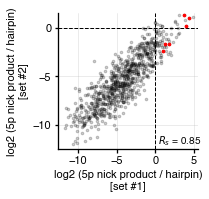

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.scatter(xs, ys, s=7, color='k', alpha=.2, zorder=3, rasterized=True)
ax.scatter(xs2, ys2, s=7, color='r', alpha=1, zorder=3, rasterized=True)

ax.set_xlabel('log2 (5p nick product / hairpin)\n[set #1]')
ax.set_ylabel('log2 (5p nick product / hairpin)\n[set #2]')
ax.set_yticks([-10,-5,0])
ax.set_xlim(-12.5,5.5)
ax.set_ylim(-12.5,1.5)
ax.axhline(0,color='k',ls='--',lw=1)
ax.axvline(0,color='k',ls='--',lw=1)
ax.grid(ls='-',lw=.5)
ax.text(6,-12,'$R_s$ = %.2f'%r,ha='right')
#fig.savefig(resultpath + '201123_f3c__nick5_meta.pdf',dpi=300)

In [48]:
for mir in tmp:
    n1, n2 = nick5[mir]
    n1 = np.log2(n1); n2 = np.log2(n2)
    #if n1>0 and n2>0:
    print '%s\t%.2f\t%.2f'%(mir, n1, n2)

hsa-mir-10a	1.72	-1.63
hsa-mir-10b	4.00	0.21
hsa-mir-20a	1.27	-1.66
hsa-mir-17	3.71	1.31
hsa-mir-106a	4.31	1.01
hsa-mir-92a-1	1.00	-2.35


## D. Reproducibility of 3p nick processing

In [34]:
xs, ys = zip(*nick3.values())
r = spearmanr(xs, ys)[0]
xs = np.log2(xs)
ys = np.log2(ys)
print r

0.7990169132785298


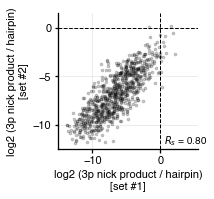

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.scatter(xs, ys, s=7, color='k', alpha=.2, zorder=3, rasterized=True)

ax.set_xlabel('log2 (3p nick product / hairpin)\n[set #1]')
ax.set_ylabel('log2 (3p nick product / hairpin)\n[set #2]')
ax.set_yticks([-10,-5,0])
ax.set_xlim(-15,5.5)
ax.set_ylim(-12.5,1.5)
ax.axhline(0,color='k',ls='--',lw=1)
ax.axvline(0,color='k',ls='--',lw=1)
ax.grid(ls='-',lw=.5)
ax.text(.5,-12,'$R_s$ = %.2f'%r)
fig.savefig(resultpath + '201123_f3d__nick3_meta.pdf',dpi=300)

In [157]:
for mir in sorted(nick3.keys(),key=lambda x: nick3[x][0]):
    n1, n2 = nick3[mir]
    n1 = np.log2(n1); n2 = np.log2(n2)
    if n1>.5 and n2>-3:
        print '%s\t%.2f\t%.2f'%(mir, n1, n2)

hsa-mir-92a-2	0.65	-0.85
hsa-mir-365b	0.86	-2.58
hsa-mir-4268	1.48	0.24
hsa-mir-128-1	1.87	-0.49
hsa-mir-16-2	2.12	-2.72


## E. Comparison with fCLIP-seq - 5p nick

In [36]:
fclipexcel = pd.ExcelFile('supplementary/Kim_2017_s2.xlsx')
fclip293t = fclipexcel.parse('HEK293T_miRBase', index_col=0)
both293t = fclip293t[(fclip293t['Group5p']!='Unidentified')&
                     (fclip293t['Group3p']!='Unidentified')]
both293t.iloc[:1, :8]

,Group5p,Group3p,Overhang,miRBaseOverhang,Contig,Strand,mirBasePosition5p,fCLIPPosition5p
miRNA,,,,,,,,
hsa-let-7a-1,Matched site,Matched site,1.0,1.0,chr9,+,94175962.0,94175962


In [37]:
bedcols = [ 'chr', 'start', 'end', 'miRNA', 'strand' ]
bedfile = 'supplementary/fCLIP/293T/293T_191115_genome-annot_1881-pris_mp1_sp1.bed.gz'
ftbl = pd.read_table(gzip.open(bedfile,'rb'),usecols=[0,1,2,15,17],names=bedcols)
ftbl['start']=ftbl['start']+1
ftbl.head(1)

,chr,start,end,miRNA,strand
0,chr1,17311,17415,hsa-mir-6859-1,-


In [39]:
FCLIPCUT = 5
xpos = range(-5,100)
tbl5, tbl3 = pd.DataFrame(columns=xpos), pd.DataFrame(columns=xpos)
for mir, row in both293t.iterrows():
    c5,c3,strand = row[['fCLIPPosition5p','fCLIPPosition3p','Strand']].astype(str)
    if c5.find(';')>=0 or c3.find(';')>=0:
        continue
    c5 = int(c5)
    c3 = int(c3)
    sub = ftbl[ftbl['miRNA']==mir]
    if strand=='+':
        premir = sub[(sub['start']==c5)&(sub['end']==c3)]
        if len(premir)>=FCLIPCUT:
            cut5 = sub[sub['start']==c5]
            cut3 = sub[sub['end']==c3]
            tbl3.loc[mir] = pd.Series(Counter(cut5['end']-c3))
            tbl5.loc[mir] = pd.Series(Counter(c5-cut3['start']))
    else:
        premir = sub[(sub['start']==c3)&(sub['end']==c5)]
        if len(premir)>=FCLIPCUT:
            cut5 = sub[sub['end']==c5]
            cut3 = sub[sub['start']==c3]
            tbl3.loc[mir] = pd.Series(Counter(-cut5['start']+c3))
            tbl5.loc[mir] = pd.Series(Counter(cut3['end']-c5))
tbl3 = tbl3.fillna(0).sort_index()
tbl5 = tbl5.fillna(0).sort_index()
print len(tbl3), len(tbl5)

181 181


In [40]:
tbl3['5nick'] = tbl3[range(3,20)].sum(axis=1)/tbl3[0]
tbl5['3nick'] = tbl5[range(3,20)].sum(axis=1)/tbl5[0]

In [41]:
pscnt = .0002
comp5 = {}
for mir in tbl3.index:
    ps, pe = preposition[mir]
    if ps<1 or pe>125 or mir not in set(clvn5.index):
        continue
    unc3 = clvn3.loc[[mir]].reset_index().set_index(['rstart'])
    unc3 = unc3.reindex(range(ps-WINDOW,ps+WINDOW+1)).sum()
    hpn = clvh.loc[[mir]]
    hpn = hpn[hpn.apply(lambda x: (x['rstart'] in range(ps-WINDOW,ps+WINDOW+1)) and 
                                  (x['rend'] in range(pe-WINDOW,pe+WINDOW+1)),axis=1)].sum()
    if hpn['set1']>=FCLIPCUT:#RCUTOFFH:
        comp5[mir] = (np.log2(unc3['set1']/hpn['set1']+pscnt),
                      np.log2(tbl3.loc[mir,'5nick']+pscnt))
print len(comp5)

169


In [42]:
xs, ys = zip(*comp5.values())
r, p = spearmanr(xs,ys)
print r, p

0.16495666226719974 0.03209499268249828


In [50]:
for mir in tmp:
    if mir in comp5:
        print mir,comp5[mir]

hsa-mir-10b (4.00855292571711, -12.287712379549449)
hsa-mir-20a (1.2802267244806578, -10.438046652633881)
hsa-mir-17 (3.736293474668332, -10.340586811532525)
hsa-mir-92a-1 (0.9967218392989076, -6.6733503692374585)


Text(-11,-2,u'N = 169\n$R_s$ = 0.16\np = 0.032')

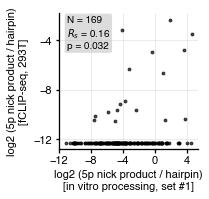

In [194]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.scatter(xs, ys, s=8, color='k', alpha=.7, zorder=2, rasterized=True)
ax.set_xlabel('log2 (5p nick product / hairpin)\n[in vitro processing, set #1]')
ax.set_ylabel('log2 (5p nick product / hairpin)\n[fCLIP-seq, 293T]')
ax.set_xticks(range(-12,5,4))
ax.set_yticks(range(-12,-3,4))
ax.grid(ls='-',lw=.5)
ax.text(-11,-2,'N = %s\n$R_s$ = %.2f\np = %.3f'%(len(xs),r,p),va='top',
       bbox={'pad':.2,'color':'#bababa','alpha':.5,'boxstyle':'round','lw':0})
#fig.savefig(resultpath + '201117_f3__nick5_fcilp.pdf',dpi=300)

In [195]:
for m in sorted(comp5.keys(),key=lambda x:-comp5[x][1]):
    vitro, vivo = comp5[m]
    if vitro>-8 and vivo>-8:
        print '%s\t%.2f\t%.2f\t%.2f\t%.2f'%(m, vitro, vivo, effs[m], homs[m])

hsa-mir-4746	1.85	-2.32	1.85	0.18
hsa-mir-3607	-4.14	-3.17	0.17	0.04
hsa-mir-181b-2	4.59	-3.46	0.00	0.10
hsa-mir-374b	3.57	-4.75	0.00	0.00
hsa-mir-192	-0.41	-4.95	2.45	0.18
hsa-mir-181b-1	-3.28	-6.35	0.83	0.42
hsa-mir-92a-1	1.00	-6.67	3.67	0.62


## F. Comparison with fCLIP-seq - 3p nick

In [51]:
pscnt = .0002
comp3 = {}
for mir in tbl5.index:
    ps, pe = preposition[mir]
    if ps<1 or pe>125 or mir not in set(clvn5.index):
        continue
    unc5 = clvn5.loc[[mir]].reset_index().set_index(['rend'])
    unc5 = unc5.reindex(range(pe-WINDOW,pe+WINDOW+1)).sum()
    hpn = clvh.loc[[mir]]
    hpn = hpn[hpn.apply(lambda x: (x['rstart'] in range(ps-WINDOW,ps+WINDOW+1)) and 
                                  (x['rend'] in range(pe-WINDOW,pe+WINDOW+1)),axis=1)].sum()
    if hpn['set1']>=FCLIPCUT:#RCUTOFFH:
        comp3[mir] = (np.log2(unc5['set1']/hpn['set1']+pscnt),
                      np.log2(tbl5.loc[mir,'3nick']+pscnt))
print len(comp3)

169


In [65]:
np.log2(nick3['hsa-mir-30c-2'])

array([ 0.33162149, -3.02553509])

In [60]:
comp3['hsa-mir-30c-2']

(0.33521298122558285, -12.287712379549449)

In [54]:
[m for m in comp3 if comp3[m][0]>0 and comp3[m][1]<-12]

[u'hsa-mir-449b',
 u'hsa-mir-1180',
 u'hsa-mir-107',
 u'hsa-mir-365b',
 u'hsa-mir-1249',
 u'hsa-mir-181b-2',
 u'hsa-mir-15b',
 u'hsa-mir-4326',
 u'hsa-mir-30c-2']

In [62]:
xs, ys = zip(*comp3.values())
r, p = spearmanr(xs,ys)
print r, p

-0.06436815701112197 0.4057260711022638


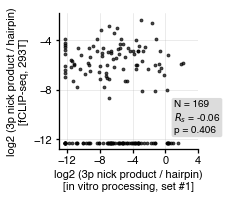

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.scatter(xs, ys, s=8, color='k', alpha=.7, zorder=2, rasterized=True)
ax.set_xlabel('log2 (3p nick product / hairpin)\n[in vitro processing, set #1]')
ax.set_ylabel('log2 (3p nick product / hairpin)\n[fCLIP-seq, 293T]')
ax.set_xticks(range(-12,5,4))
ax.set_yticks(range(-12,-3,4))
ax.grid(ls='-',lw=.5)
ax.text(1,-11.5,'N = %s\n$R_s$ = %.2f\np = %.3f'%(len(xs),r,p),
       bbox={'pad':.2,'color':'#bababa','alpha':.5,'boxstyle':'round','lw':0})
fig.savefig(resultpath + '201123_f3g__nick3_fcilp.pdf',dpi=300)

In [199]:
for m in sorted(comp3.keys()):
    vitro, vivo = comp3[m]
    if vitro>-2 and vivo>-6:
        print '%s\t%.2f\t%.2f\t%.2f\t%.2f'%(m, vitro, vivo, effs[m], homs[m])

hsa-mir-128-1	1.89	-5.91	3.85	0.27
hsa-mir-1301	-0.62	-4.87	4.14	0.32
hsa-mir-148b	-1.62	-2.58	2.94	0.41
hsa-mir-16-2	2.18	-5.84	4.20	0.63
hsa-mir-181d	-1.11	-3.90	0.65	0.13
hsa-mir-191	-0.81	-5.92	2.70	0.36
hsa-mir-22	-1.29	-5.98	3.40	0.54
hsa-mir-26b	0.35	-5.15	4.91	0.69
